In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
X_test = pd.read_csv('saved_datasets/X_test.csv')
X_train = pd.read_csv('saved_datasets/X_train.csv')
X_val = pd.read_csv('saved_datasets/X_val.csv')
y_test = pd.read_csv('saved_datasets/y_test.csv')
y_train = pd.read_csv('saved_datasets/y_train.csv')
y_val = pd.read_csv('saved_datasets/y_val.csv')

In [3]:
X_val.head()

,product_id,add_to_cart_order,user_id,order_number,days_since_prior_order,avg_days_since_prior_order,total_orders,avg_products,order_dow_0,order_dow_1,...,department_pets,department_produce,department_snacks,most_common_order_dow_0,most_common_order_dow_1,most_common_order_dow_2,most_common_order_dow_3,most_common_order_dow_4,most_common_order_dow_5,most_common_order_dow_6
0,7649,9,210,63,3.0,3.221311,100,8.868852,0,0,...,0,0,0,1,0,0,0,0,0,0
1,33731,14,462,54,7.0,5.718750,59,10.696970,0,0,...,0,0,0,0,1,0,0,0,0,0
2,43086,4,465,12,1.0,9.378378,41,8.756757,0,1,...,0,1,0,0,0,0,0,0,1,0
3,28204,3,1866,18,4.0,4.044944,97,4.648352,0,0,...,0,1,0,0,0,0,0,0,1,0
4,13263,7,1072,15,6.0,7.100000,15,8.050000,0,1,...,0,0,0,0,1,0,0,0,0,0


In [4]:
y_val.head()

,reordered
0,1
1,1
2,0
3,1
4,1


# Dealing with distribution shift

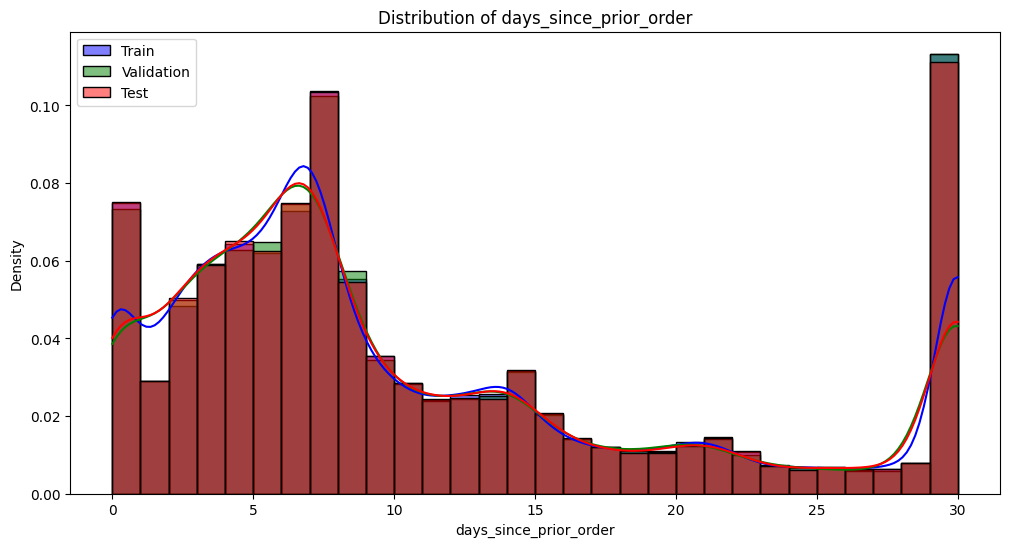

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution comparison for a given feature
def plot_distribution_comparison(feature, bins=30):
    plt.figure(figsize=(12, 6))
    sns.histplot(X_train[feature], color='blue', label='Train', bins=bins, kde=True, stat='density')
    sns.histplot(X_val[feature], color='green', label='Validation', bins=bins, kde=True, stat='density')
    sns.histplot(X_test[feature], color='red', label='Test', bins=bins, kde=True, stat='density')
    plt.legend()
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

# Plotting distribution comparison for 'days_since_prior_order'
plot_distribution_comparison('days_since_prior_order')


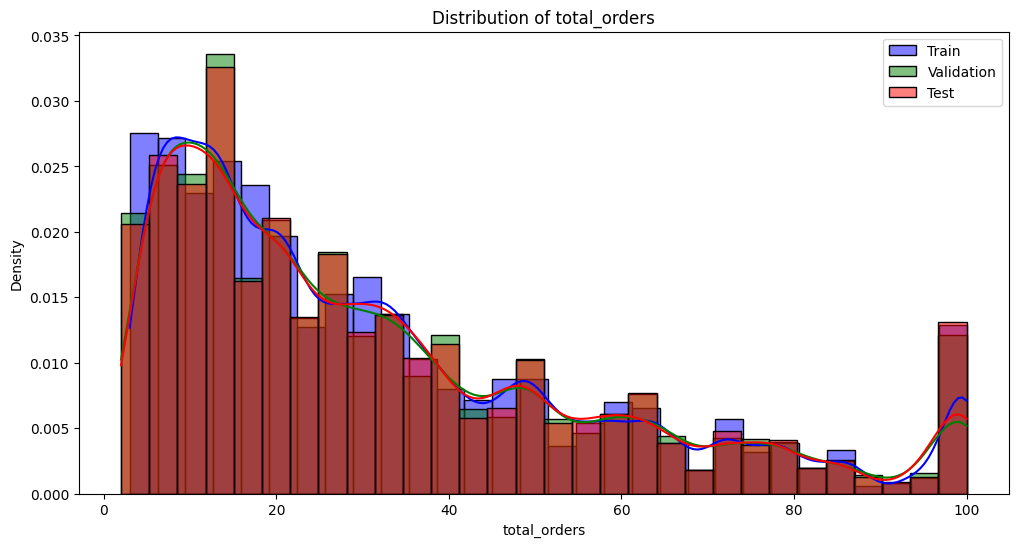

In [6]:
# Plotting distribution comparison for 'total_orders'
plot_distribution_comparison('total_orders')

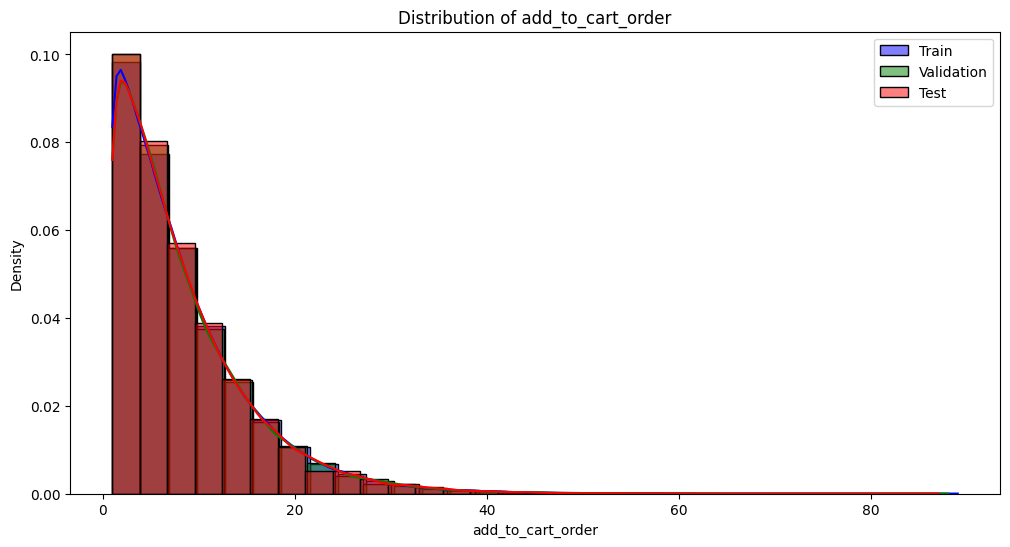

In [7]:
# Plotting distribution comparison for 'add_to_cart_order'
plot_distribution_comparison('add_to_cart_order')

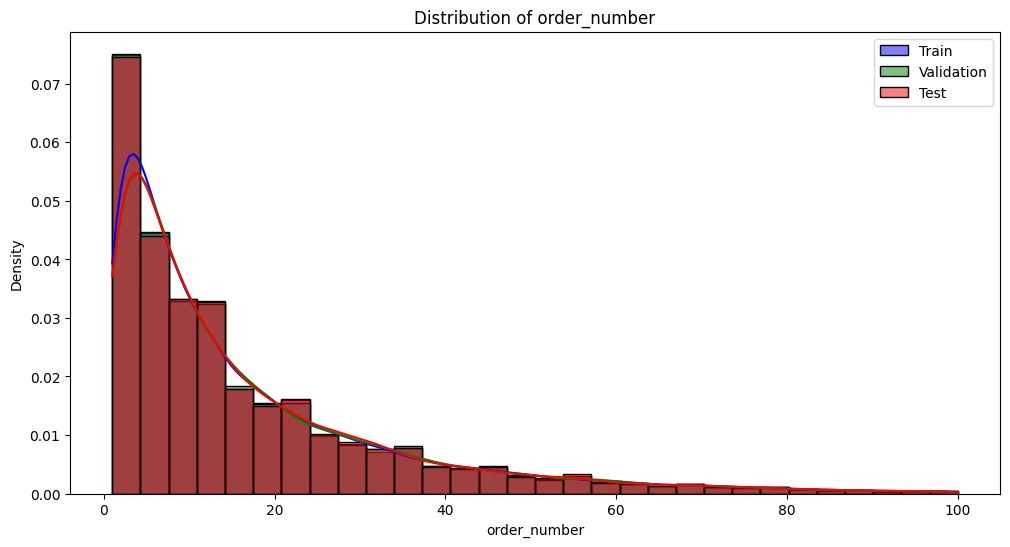

In [8]:
# Plotting distribution comparison for 'order_number'
plot_distribution_comparison('order_number')

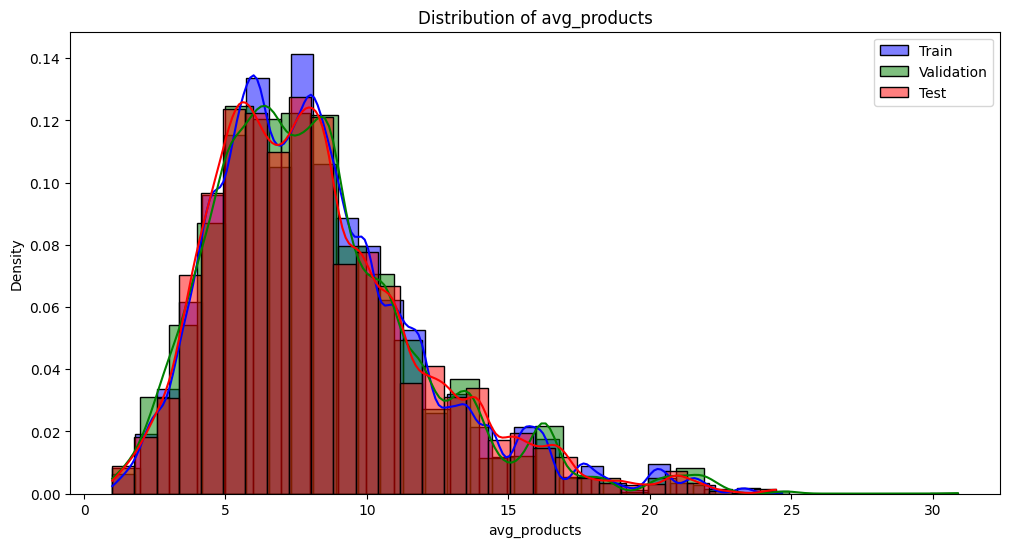

In [9]:
# Plotting distribution comparison for 'avg_products'
plot_distribution_comparison('avg_products')

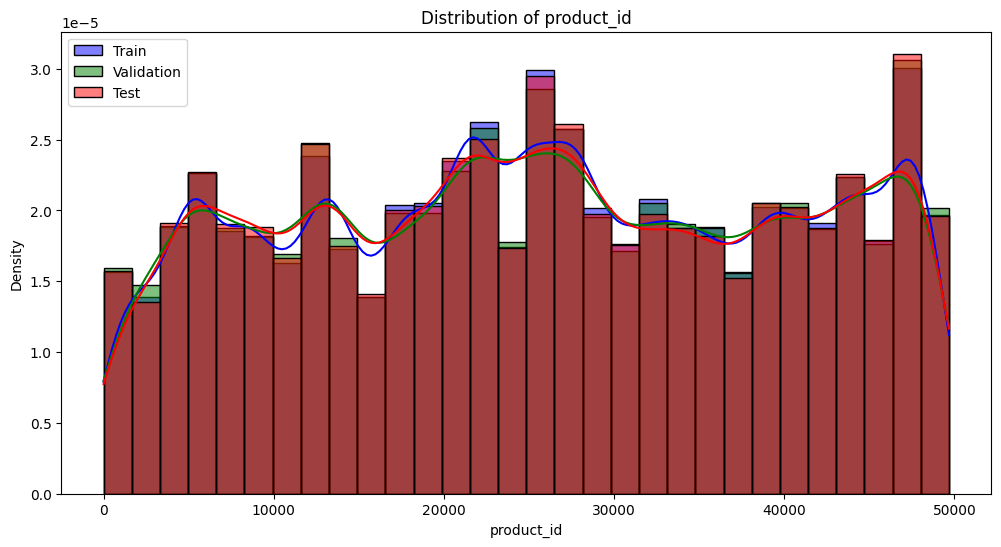

In [10]:
# Plotting distribution comparison for 'product_id'
plot_distribution_comparison('product_id')

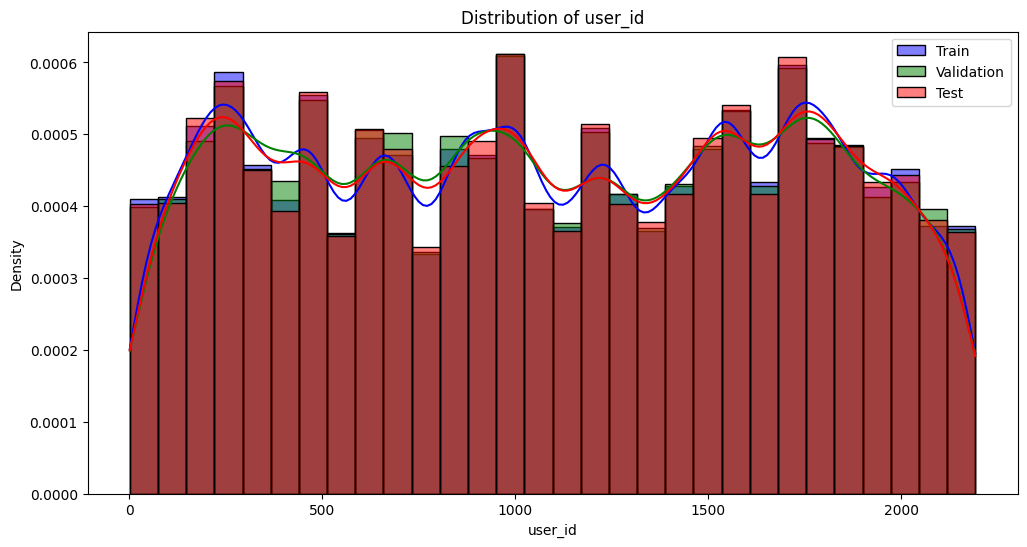

In [11]:
# Plotting distribution comparison for 'user_id'
plot_distribution_comparison('user_id')

In [12]:
from scipy.stats import ks_2samp

features = ['add_to_cart_order', 'order_number', 'days_since_prior_order', 'total_orders','product_id', 'user_id']

def compare_distributions(feature):
    stat, p_value = ks_2samp(X_train[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

for feature in features:
    compare_distributions(feature)



Kolmogorov-Smirnov test for add_to_cart_order between Train and Validation: Statistic=0.0062, P-value=0.0741
Kolmogorov-Smirnov test for add_to_cart_order between Train and Test: Statistic=0.0023, P-value=0.9431
Kolmogorov-Smirnov test for order_number between Train and Validation: Statistic=0.0017, P-value=0.9996
Kolmogorov-Smirnov test for order_number between Train and Test: Statistic=0.0039, P-value=0.3998
Kolmogorov-Smirnov test for days_since_prior_order between Train and Validation: Statistic=0.0044, P-value=0.3691
Kolmogorov-Smirnov test for days_since_prior_order between Train and Test: Statistic=0.0056, P-value=0.0811
Kolmogorov-Smirnov test for total_orders between Train and Validation: Statistic=0.0094, P-value=0.0010
Kolmogorov-Smirnov test for total_orders between Train and Test: Statistic=0.0063, P-value=0.0326
Kolmogorov-Smirnov test for product_id between Train and Validation: Statistic=0.0073, P-value=0.0188
Kolmogorov-Smirnov test for product_id between Train and Tes

In [13]:
# Downsample the train set to match the distribution of the validation set for 'total_orders'
train_indices = X_train['total_orders'].sample(n=len(X_val), random_state=42).index
X_train_resampled = X_train.loc[train_indices]
y_train_resampled = y_train.loc[train_indices]

from scipy.stats import ks_2samp

def compare_distributions_resampled(feature, X_train_resampled, X_val, X_test):
    stat, p_value = ks_2samp(X_train_resampled[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train_resampled[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

compare_distributions_resampled('total_orders', X_train_resampled, X_val, X_test)


Kolmogorov-Smirnov test for total_orders between Resampled Train and Validation: Statistic=0.0111, P-value=0.0027
Kolmogorov-Smirnov test for total_orders between Resampled Train and Test: Statistic=0.0081, P-value=0.0379


In [14]:
# Downsample the train set to match the distribution of the validation set for 'product_id'
train_indices = X_train['product_id'].sample(n=len(X_val), random_state=42).index
X_train_resampled = X_train.loc[train_indices]
y_train_resampled = y_train.loc[train_indices]

from scipy.stats import ks_2samp

def compare_distributions_resampled(feature, X_train_resampled, X_val, X_test):
    stat, p_value = ks_2samp(X_train_resampled[feature], X_val[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Validation: Statistic={stat:.4f}, P-value={p_value:.4f}")

    stat, p_value = ks_2samp(X_train_resampled[feature], X_test[feature])
    print(f"Kolmogorov-Smirnov test for {feature} between Resampled Train and Test: Statistic={stat:.4f}, P-value={p_value:.4f}")

compare_distributions_resampled('product_id', X_train_resampled, X_val, X_test)

Kolmogorov-Smirnov test for product_id between Resampled Train and Validation: Statistic=0.0048, P-value=0.5629
Kolmogorov-Smirnov test for product_id between Resampled Train and Test: Statistic=0.0038, P-value=0.7876


# Handling imbalanced datasets for the training data

In [15]:
import pandas as pd

class_distribution = y_train['reordered'].value_counts(normalize=True)
print(class_distribution)

1    0.583513
0    0.416487
Name: reordered, dtype: float64


In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert y_resampled to a numpy array
y_resampled_array = y_resampled.to_numpy().ravel()

# Convert y_resampled_array to a pandas Series
y_resampled_series = pd.Series(y_resampled_array)

class_distribution_resampled = y_resampled_series.value_counts(normalize=True)
print(class_distribution_resampled)


0    0.5
1    0.5
dtype: float64


# Correlations

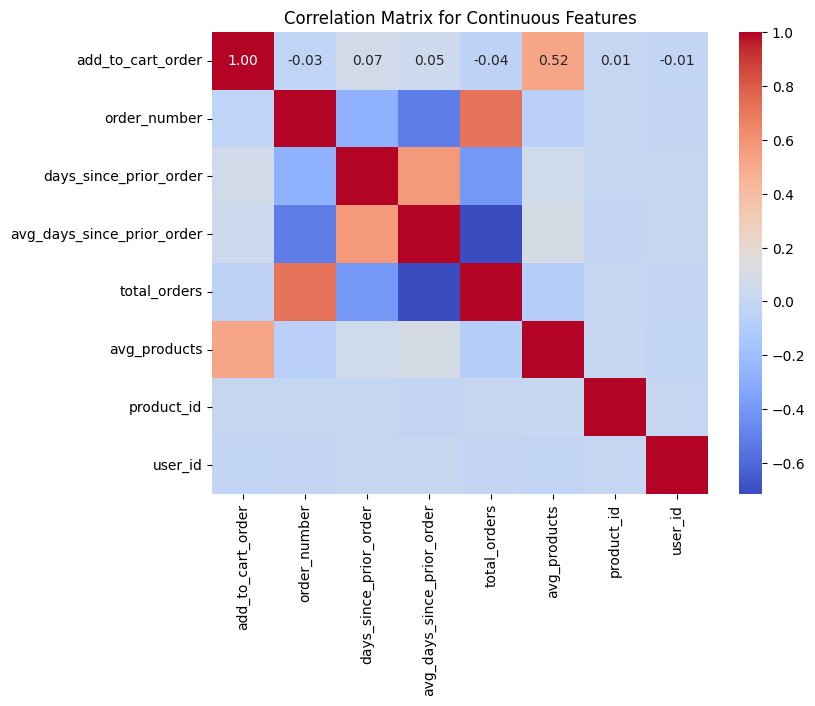

In [17]:
# Select continuous features
continuous_features = ['add_to_cart_order','order_number', 
                       'days_since_prior_order', 'avg_days_since_prior_order', 'total_orders', 'avg_products', 'product_id', 'user_id'] 

corr_continuous = X_train[continuous_features].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_continuous, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


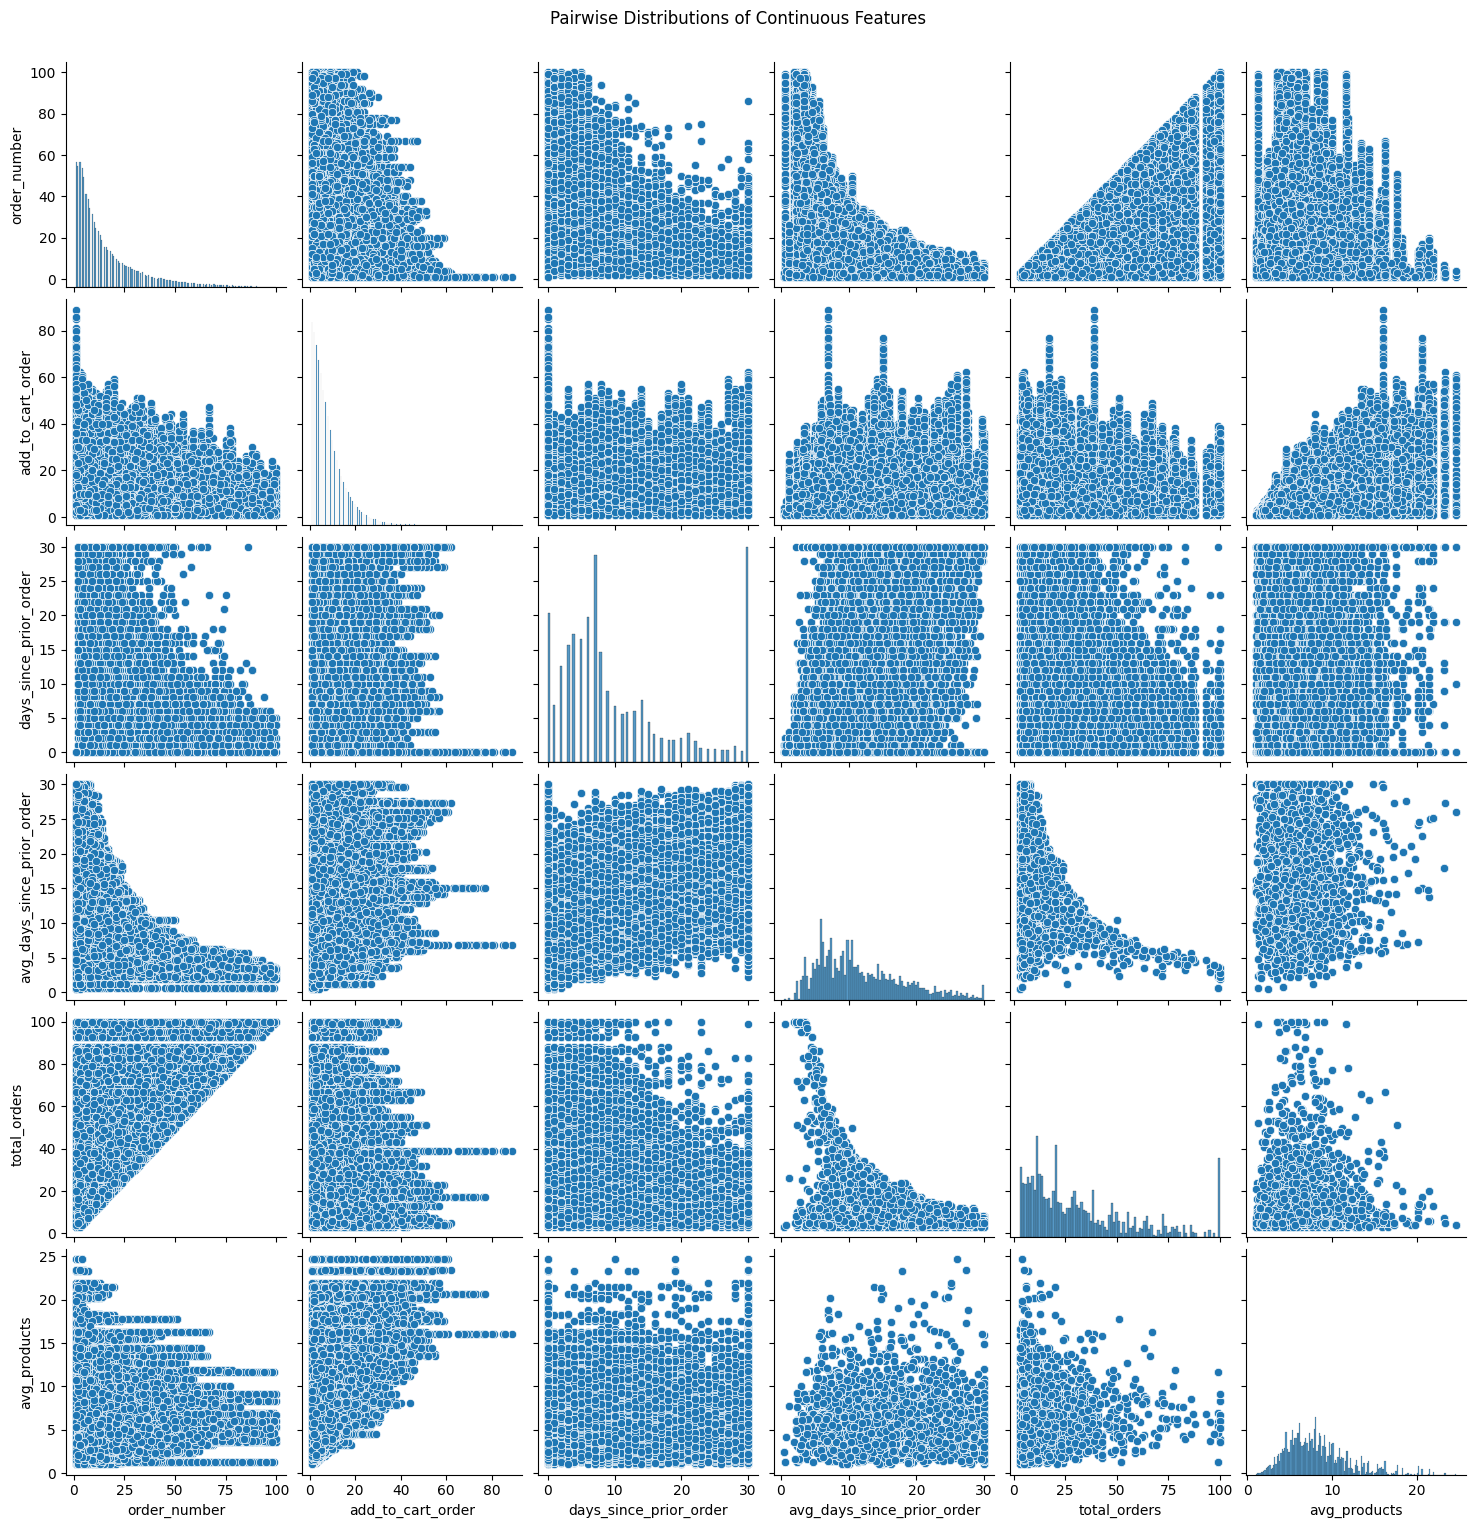

In [18]:
# pairplot to visualize pairwise relationships between the features
features = ['order_number', 'add_to_cart_order', 'days_since_prior_order', 'avg_days_since_prior_order', 'total_orders', 'avg_products']
sns.pairplot(X_train[features])
plt.suptitle('Pairwise Distributions of Continuous Features', y=1.02)
plt.show()


# Distributions

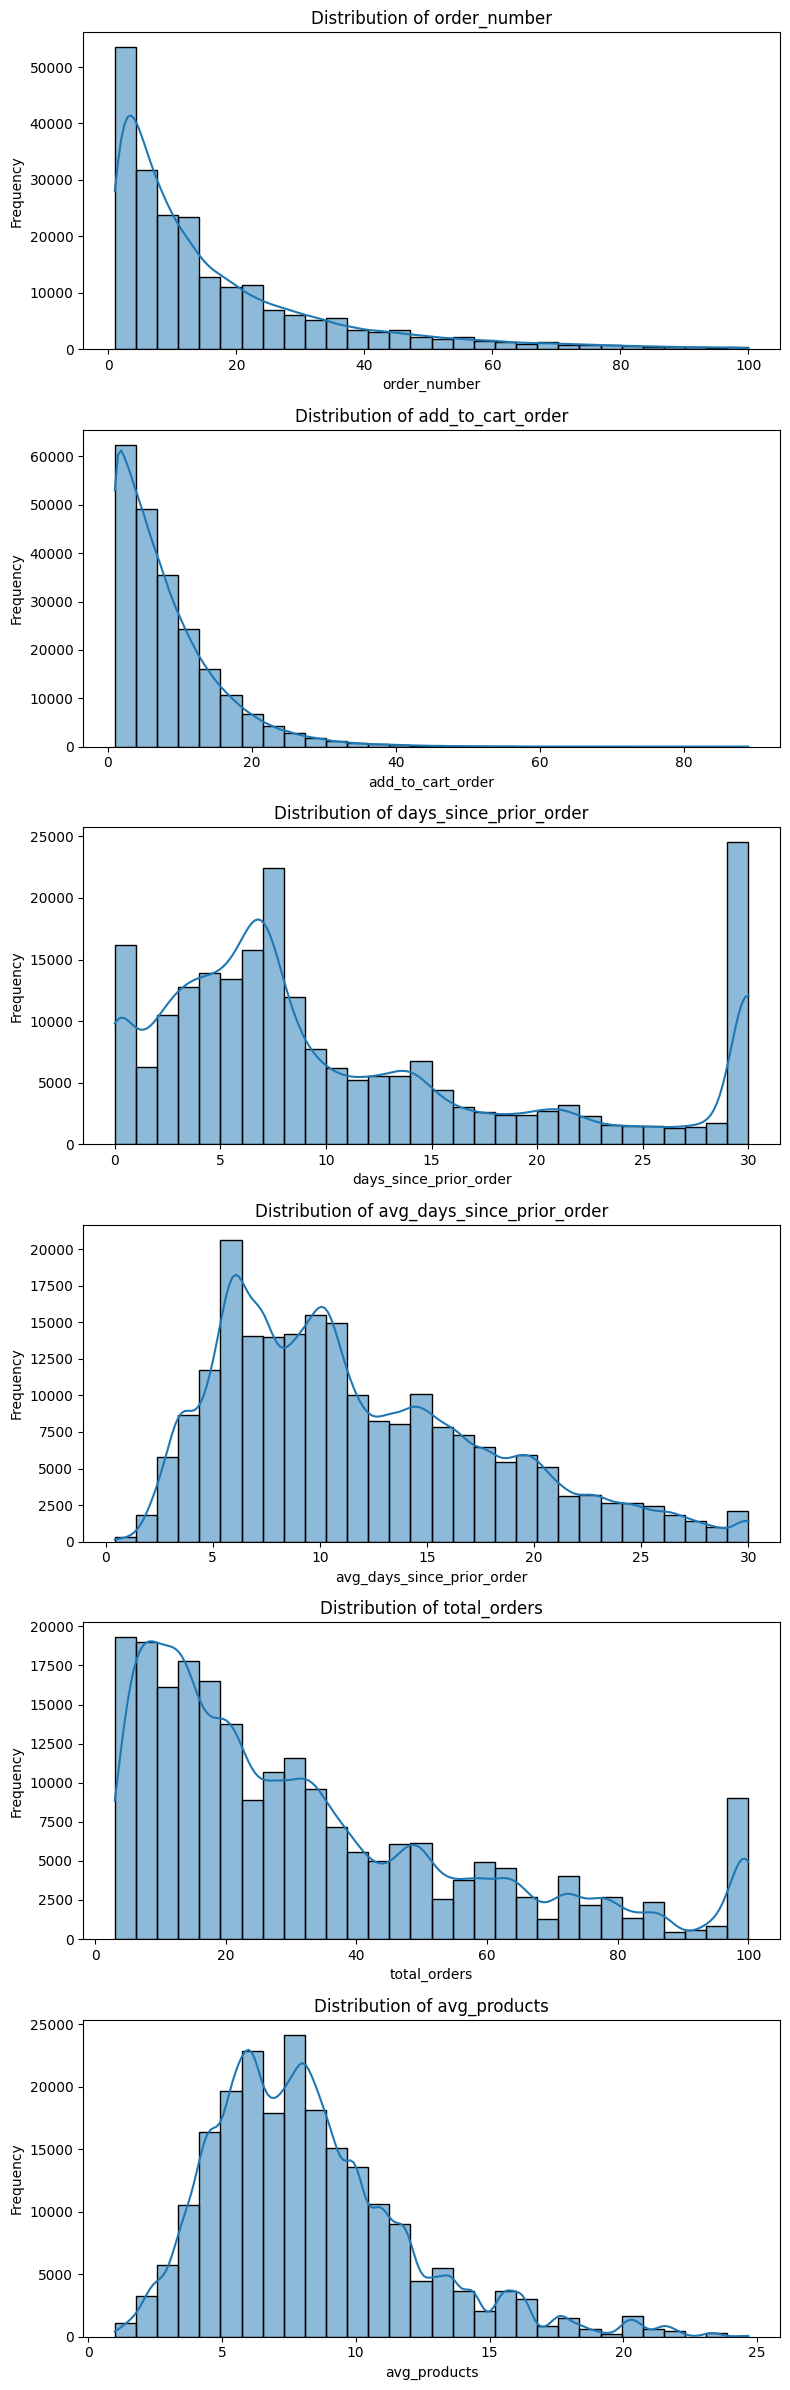

In [19]:
# Distribution of Features
n_features = len(features)
fig, axes = plt.subplots(n_features, 1, figsize=(8, 4 * n_features))

for i, feature in enumerate(features):
    sns.histplot(X_train[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Densities

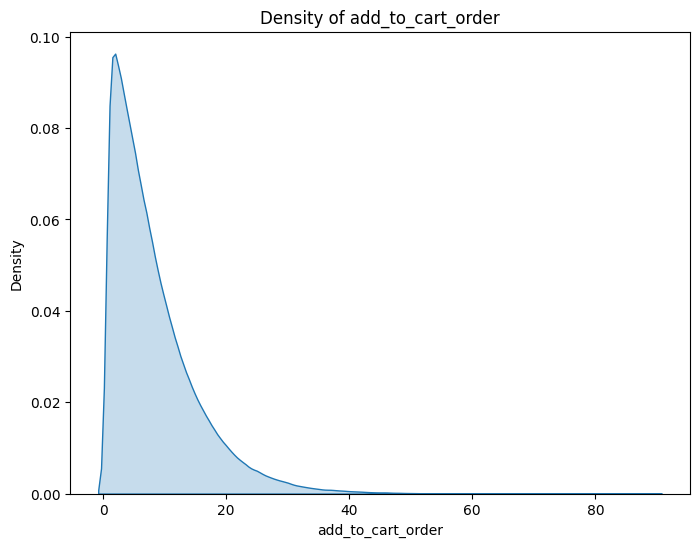

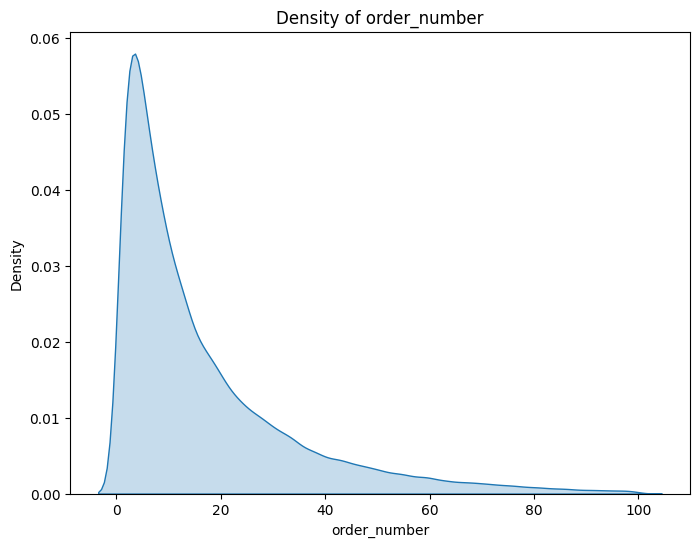

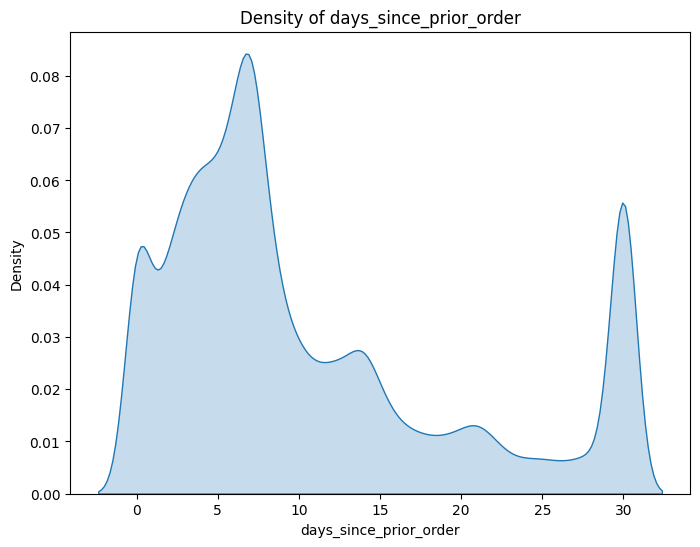

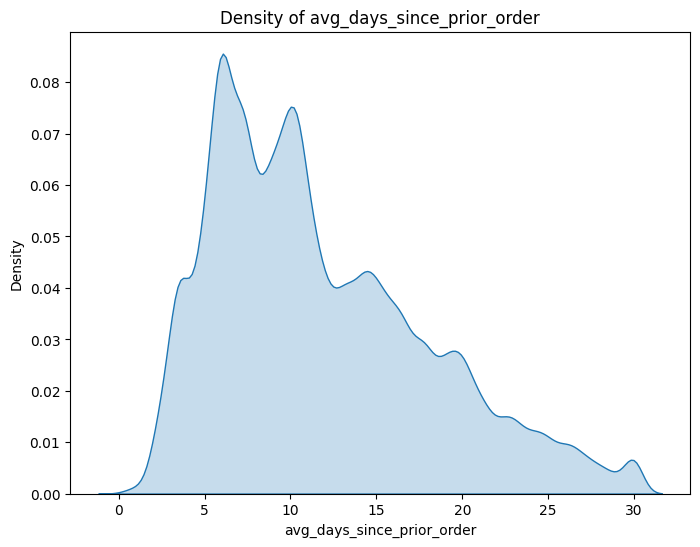

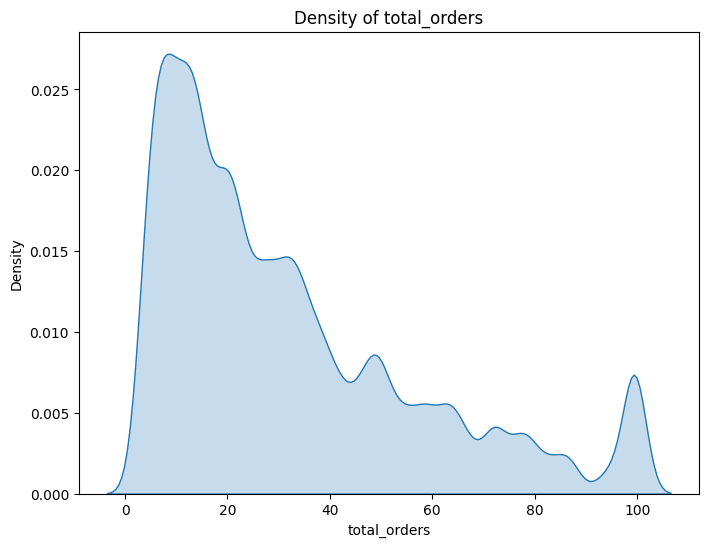

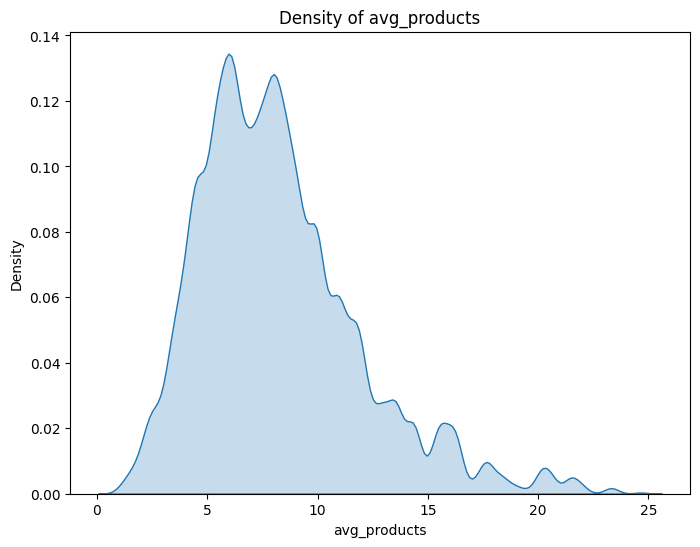

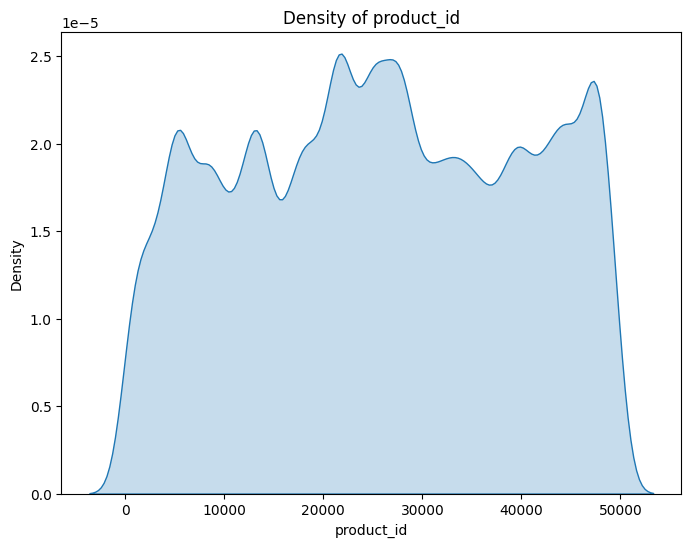

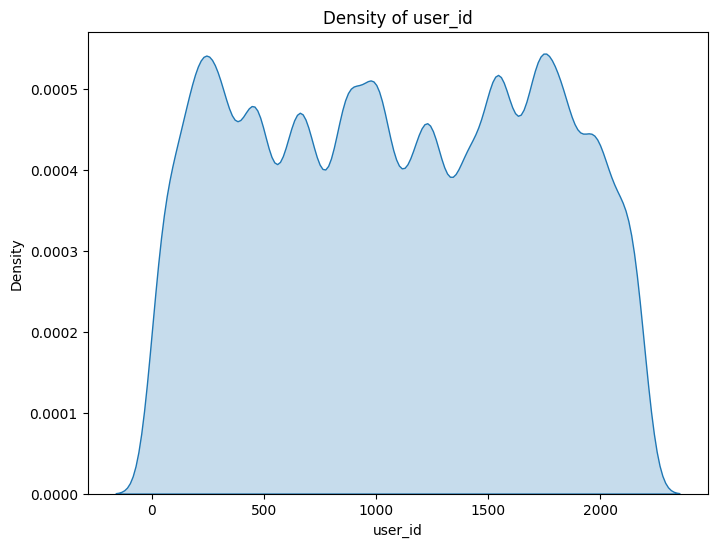

In [20]:
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(X_train[feature], shade=True)
    plt.title(f'Density of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


# Information Leakage Analysis

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


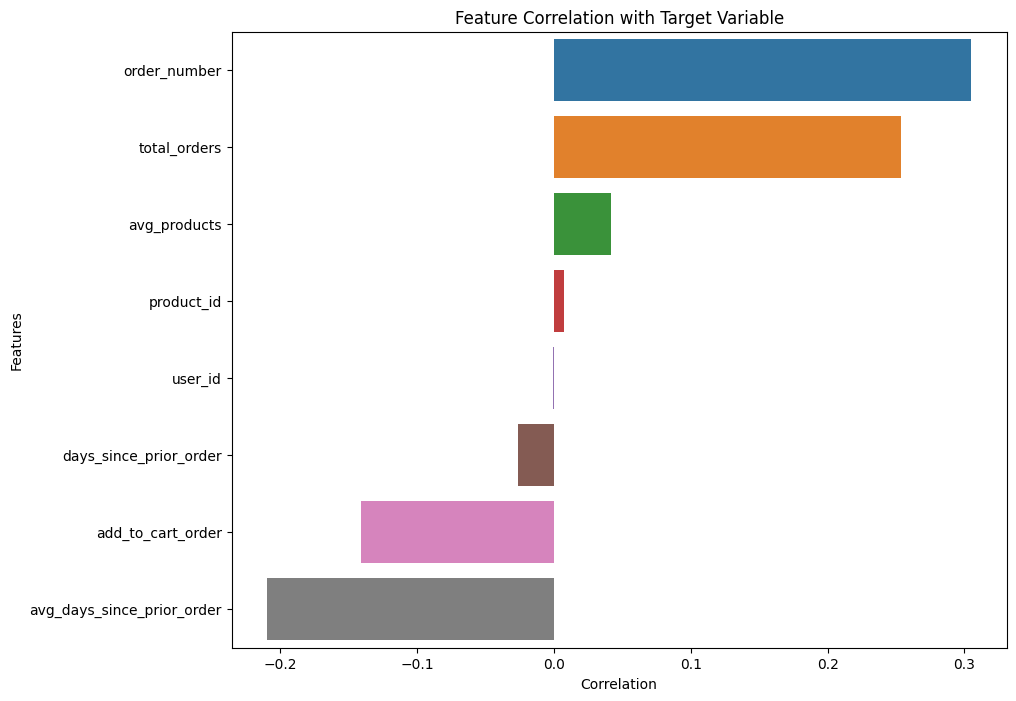

In [21]:
# Compute the correlation between features and the target variable
correlations = X_train[continuous_features].corrwith(y_train['reordered'])
correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[continuous_features], y_train['reordered'])

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### There are no features have surprisingly high importance score compared to our expectations. In addition, if there are features that are highly correlated with the target variable, that might be leaking information. Based on the output, we found that there are no features that are very highly correlated with the target variable. Therefore, by combining above results, there is no risk of imformation leakage.

## Feature Selection

In [ ]:
X_train = X_resampled
y_train = y_resampled

In [ ]:
# impute any missing values with the most frequent value in each column
from sklearn.impute import SimpleImputer
if X_train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='most_frequent')
    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=X_train.columns)


### Feature selection : Lasso

In [ ]:
from sklearn.linear_model import LassoLarsCV
import pandas as pd


model = LassoLarsCV(cv=5)

model.fit(X_train, y_train)

selected_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
selected_features = selected_features[selected_features['Coefficient'] != 0]

print("Selected Features:")
print(selected_features)


Selected Features:
                        Feature   Coefficient
0                    product_id  5.110014e-08
1             add_to_cart_order -1.438821e-02
3                  order_number  7.574661e-03
4        days_since_prior_order  6.495337e-03
5    avg_days_since_prior_order -9.851078e-03
..                          ...           ...
175     most_common_order_dow_1  1.345531e-02
176     most_common_order_dow_2 -4.766964e-03
177     most_common_order_dow_3 -2.464167e-02
179     most_common_order_dow_5  5.674284e-03
180     most_common_order_dow_6 -4.363221e-03

[129 rows x 2 columns]


### Run RF on Lasso selected features 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X_train_selected = X_train[selected_features['Feature']]

rf_model = RandomForestClassifier()
rf_model.fit(X_train_selected, y_train)

feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': selected_features['Feature'], 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                       Feature  Importance
3                 order_number    0.164952
0                   product_id    0.104012
1            add_to_cart_order    0.101925
4       days_since_prior_order    0.099900
6                 total_orders    0.091201
..                         ...         ...
134            aisle_skin care    0.000100
95      aisle_kitchen supplies    0.000085
22   aisle_baby bath body care    0.000076
27                aisle_beauty    0.000057
77          aisle_frozen juice    0.000045

[129 rows x 2 columns]


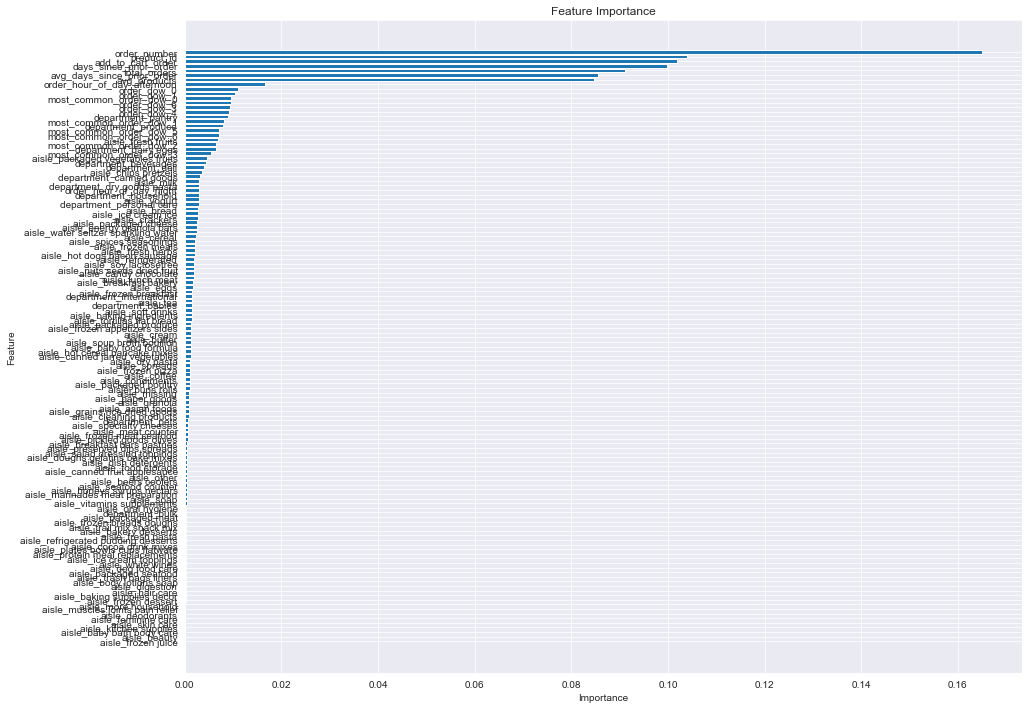

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


### Select top 20 features and run RFECV 

In [ ]:
top_20_features = feature_importance_df.head(20)

Top 12 features: ['order_number', 'product_id', 'add_to_cart_order', 'days_since_prior_order', 'total_orders', 'avg_days_since_prior_order', 'avg_products', 'order_hour_of_day_afternoon', 'order_dow_0', 'order_dow_1', 'most_common_order_dow_0', 'order_dow_6', 'order_dow_3']


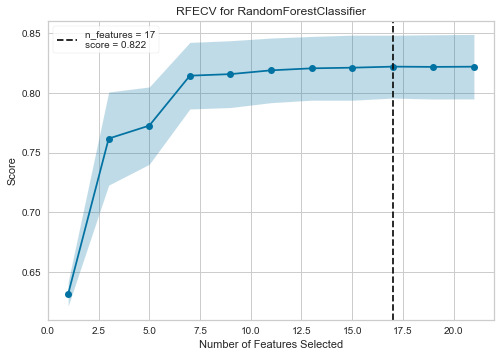

In [102]:
# pip install -U yellowbrick
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier

selected_cols = top_20_features['Feature'].tolist()

visualizer = RFECV(RandomForestClassifier(), step=2, cv=3, n_jobs=-1)

# Fit the visualizer on the training data
visualizer.fit(X_train[selected_cols], y_train)

# Get the ranking of the features
ranking = visualizer.ranking_

top_12_idx = [i for i, x in enumerate(ranking) if x in range(1, 13)]
top_12_features = [selected_cols[i] for i in top_12_idx]
print("Top 12 features:", top_12_features[0:13])



visualizer.show()
plt.show()

The application of RFECV to our dataset reveals a distinct plateau in the feature importance plot at around 15 features.  
This indicates that beyond this point, additional features contribute minimally to the model's predictive power.   
Therefore, we will proceed with these 15 features for further modeling and analysis.

In [103]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
top_15_features=top_12_features[0:15]
X_train_selected = X_train[top_15_features]
model = RandomForestClassifier()
model.fit(X_train_selected, y_train)


# Transform X_val to include only the top 15 features
X_val_selected = X_val[top_15_features]

# Make predictions on the transformed validation set
y_pred = model.predict(X_val_selected)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.7498335921899267
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68     22506
           1       0.77      0.82      0.79     31578

    accuracy                           0.75     54084
   macro avg       0.74      0.73      0.74     54084
weighted avg       0.75      0.75      0.75     54084

Confusion Matrix:
 [[14520  7986]
 [ 5544 26034]]


In [104]:
X_test_selected = X_test[top_15_features]

Explained variance ratio: [0.17591914 0.10388864 0.09502954 0.07923435 0.07650866 0.07540128
 0.06677547 0.06632001 0.06588763 0.05502586 0.05023611 0.03136659
 0.02445567 0.01984789 0.01410316]
Cumulative explained variance: [0.17591914 0.27980778 0.37483732 0.45407167 0.53058033 0.60598161
 0.67275707 0.73907709 0.80496472 0.85999058 0.91022669 0.94159328
 0.96604895 0.98589684 1.        ]
Number of components to retain for >90% variance: 11


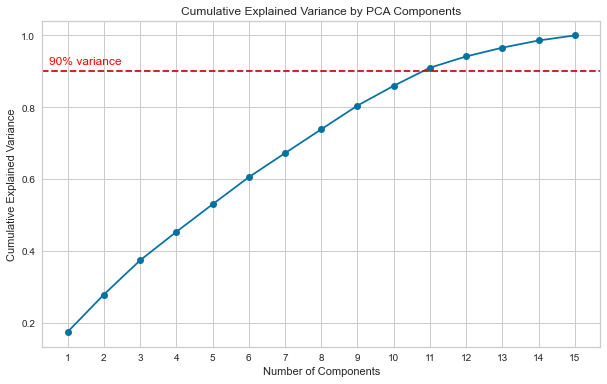

In [105]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

pca = PCA(n_components=15)

# Fit PCA on the standardized training data
X_train_pca = pca.fit_transform(X_train_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)

n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain for >90% variance: {n_components}")
import matplotlib.pyplot as plt


# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.xticks(range(1, 16))
plt.axhline(y=0.90, color='r', linestyle='--')  # Add a horizontal line at 90% variance
plt.text(0.5, 0.92, '90% variance', color = 'red', fontsize=12)
plt.show()

Upon exploring PCA on all features, it was observed that the cumulative explained variance plot showed a linear trend without a plateau. This indicates that each principal component contributes similarly to the variance, suggesting no inherent lower-dimensional structure for effective dimensionality reduction. Given this, and the equal importance of original features, PCA may not offer substantial benefits for this dataset. Therefore, it has been decided not to use PCA and to explore alternative methods for feature selection and dimensionality reduction that better align with the data characteristics and analysis goals.

### Use X_train_selected, X_val_selected, X_test_selected to proceed on building the model.

In [106]:
# save x_train_selected, x_val_selected, x_test_selected
X_train_selected.to_csv('saved_datasets/X_train_selected.csv', index=False)
X_val_selected.to_csv('saved_datasets/X_val_selected.csv', index=False)
X_test_selected.to_csv('saved_datasets/X_test_selected.csv', index=False)

